# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [9]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq
import requests


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [10]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

 11%|█         | 1/9 [00:00<00:01,  5.98it/s]

<_io.BufferedReader name='data\\02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data\\05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>


 33%|███▎      | 3/9 [00:00<00:00, 10.53it/s]

<_io.BufferedReader name='data\\Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data\\Schwerpunktthemen_fuer_Studenten.pdf'>
<_io.BufferedReader name='data\\W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 56%|█████▌    | 5/9 [00:01<00:01,  3.33it/s]

<_io.BufferedReader name='data\\ZHAW_Zitierleitfaden_DE.pdf'>


 67%|██████▋   | 6/9 [00:02<00:01,  1.74it/s]

<_io.BufferedReader name='data\\Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:03<00:01,  1.89it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 89%|████████▉ | 8/9 [00:03<00:00,  2.06it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


' \n \n \n \n \n \n2.2.5.1 -01MB Vermeidung von Plagiaten'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [11]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [12]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 61
Preview of the first chunk: 2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung vo


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [13]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [14]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 252
2.2.5.1 -01MB Vermeidung von Plagiaten Dok.- Verantw.: mart Version 2.0 . Genehmigt 19.9.12 durch: Generalsekretär Seite 1 von 2 Rektorat Ressort Lehre Merkblatt zur Vermeidung von Plagiaten Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprechend s e- hen das Gesetz und die Rahmenprüfungsordnung für Bachelor - und Masterstudi engänge der ZHAW (RPO) in Plagiatsfällen zum Teil gravierende Sanktionen für Studierende vor. Dieses Mer k- blatt soll 


In [15]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁2.2', '.', '5.1', '▁', '-01', 'MB', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Dok', '.', '-', '▁Ver', 'ant', 'w', '.', ':', '▁mart', '▁Version', '▁2.0', '▁', '.', '▁Ge', 'nehm', 'igt', '▁19', '.9.', '12', '▁durch', ':', '▁General', 'sekretär', '▁Seite', '▁1', '▁von', '▁2', '▁Rektor', 'at', '▁Res', 'sort', '▁Lehr', 'e', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Pla', 'gia', 'te', '▁vers', 'to', 'ssen', '▁gegen', '▁grundlegende', '▁Regeln', '▁', 'wissenschaftlich', 'en', '▁Arbeiten', 's', '.', '▁Ent', 'sprechen', 'd', '▁s', '▁e', '-', '▁hen', '▁das', '▁Gesetz', '▁und', '▁die', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '▁-', '▁und', '▁Master', 'studi', '▁en', 'gänge', '▁der', '▁Z', 'HA', 'W', '▁(', 'R', 'PO', ')', '▁in', '▁Pla', 'gia', 'ts', 'fälle', 'n', '▁zum', '▁Teil', '▁gravi', 'erende', '▁San', 'ktion', 'en', '▁für', '▁Studi', 'erende', '▁vor', '.', '▁Dieses', '▁Mer', '▁k', '-', '▁', 'blatt', '</s

In [16]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', '2', '.', '2', '.', '5', '.', '1', '-', '01', '##MB', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Dok', '.', '-', 'Veran', '##tw', '.', ':', 'mar', '##t', 'Version', '2', '.', '0', '.', 'Genehm', '##igt', '19', '.', '9', '.', '12', 'durch', ':', 'Generalsekretär', 'Seite', '1', 'von', '2', 'Rektor', '##at', 'Ressort', 'Lehre', 'Merk', '##blatt', 'zur', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Pla', '##gia', '##te', 'verst', '##ossen', 'gegen', 'grundlegende', 'Regeln', 'wissenschaft', '##lichen', 'Arbeiten', '##s', '.', 'Entsprechend', 's', 'e', '-', 'hen', 'das', 'Gesetz', 'und', 'die', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##di', 'eng', '##änge', 'der', 'Z', '##H', '##AW', '(', 'R', '##PO', ')', 'in', 'Pla', '##gia', '##ts', '##fällen', 'zum', 'Teil', 'grav', '##ierende', 'Sanktionen', 'für', 'Studierende', 'vor', '.', 'Dieses', 'Mer', 'k', '-', 'bl', '##att', 'soll', '[SEP]']
Chunk 1: ['[CLS]',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [17]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

C:\Users\ich\AppData\Local\Temp\ipykernel_16940\4090508586.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [18]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [19]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 252


In [20]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [21]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

61
252


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [22]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/252 [00:00<?, ?it/s]c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/252 [00:03<14:40,  3.51s/it]c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite'

Projected dataset embeddings shape: (252, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [24]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [25]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15. Zitierleitfaden | 19 Zitierleitfaden | 20 Generative Systeme, die auf Künstlicher Intelligenz (KI) basieren, gehören zunehmend zur neuen Studien- und Berufsrealität von Lehrenden und Lernenden. Die Richtlinie KI bei


In [26]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\ich\Documents\ZHAW\4_sem\KIA\RAG-and-embeddings-KIA\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

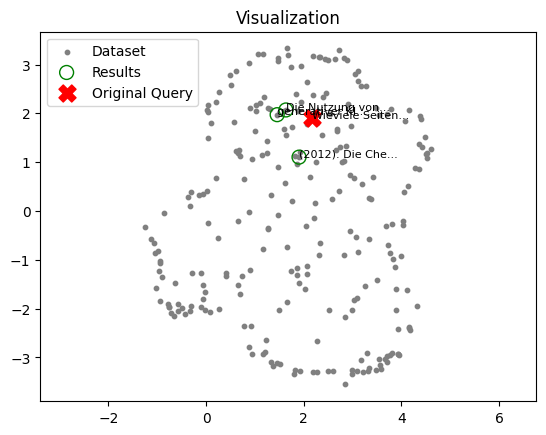

In [27]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


## 1. Embedding-Based Semantic Retrieval

We use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a new user query into a dense vector embedding and retrieve top-k similar text chunks from a FAISS index.

In [33]:
# 1. Load the embedder model
embed_model = SentenceTransformer("Sahajtomar/German-semantic")

# 2. Encode the user’s query into a dense vector
query = (
    "Welche formalen Anforderungen gelten für die "
    "Deklarationspflicht von generativer KI in einer "
    "Bachelorarbeit an der ZHAW?"
)

# Set the number of results to retrieve
k = 5

# 2. Embed & retrieve exactly as before:
q_emb = embed_model.encode([query], convert_to_numpy=True)
distances, indices = index.search(q_emb, k)
retrieved_chunks = [token_split_texts[i] for i in indices[0]]

# 3. Inspect the top‐k chunks:
for i, chunk in enumerate(retrieved_chunks, start=1):
    print(f"--- Chunk {i} ---\n{chunk}\n")

--- Chunk 1 ---
Die Nutzung von generativen KI -Systemen ist vorgängig mit der Betreuungsperson zu besprechen und in der Arbeit offenzulegen . Als generative KI -Systeme gelten digitale Werkzeuge, deren Technologien auf maschinellem Lernen beruhen (künstliche Intelligenz /KI). W-MB-Merkblatt Bachelorarbeit BSc Version: 3.1.1 gültig ab: 01.08.202 4 Seite 10 von 11 School of Management and Law Für die Offenlegung gilt im Minimum: − Bei wortwörtlicher, paraphrasierender oder sinngemässer Übernahme von Output aus genera

--- Chunk 2 ---
ven KI -Systemen an der schöpferischen Leistung eine r Arbeit sowie zur Dokumentation der Qualität des eigenen wissenschaftlichen Wirkens, muss generell in der Einleitung zur Arbeit oder im Methodenabschnitt/ -teil beschrieben werden, wie generative KI -Sys- teme in der Arbeit verwendet wurden . Zur Beschreibung gehören zwingend Ausführun- gen darüber, inwiefern generative KI -Systeme für einen Gedankenanstoss oder als Inspira- tionsquell e verwendet wurden

## 2. LLM Prompt Construction and Query Answering

Using the retrieved texts, we build a structured prompt. This prompt combines the context with our new query to request a relevant answer from the language model.


In [34]:

# 1. Build the context from the retrieved chunks
context = "\n\n".join(retrieved_chunks)

# 2. Construct the prompt (in German)
prompt = (
    "Beantworte die folgende Frage basierend auf dem bereitgestellten Kontext:\n\n"
    f"{context}\n\n"
    f"Frage: {query}"
)

# 3. Initialize the Groq 
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
url = "https://api.groq.com/openai/v1/chat/completions"


# 4. Send the request via the SDK
payload = {
    "model": "llama-3.3-70b-versatile",
    "messages": [
        {"role": "system", "content": "Du bist ein hilfreicher Assistent."},
        {"role": "user", "content": prompt}
    ],
    "temperature": 0.3,
    "max_tokens": 300
}
# Request headers
headers = {
    "Authorization": f"Bearer {groq_api_key}",
    "Content-Type": "application/json"
}

# 5. Extract and print the answer
response = requests.post(url, headers=headers, json=payload)

# Raise an error if the response failed
response.raise_for_status()

# Extract and print the response
result = response.json()
print("--- Antwort vom LLM ---")
print(result["choices"][0]["message"]["content"])

--- Antwort vom LLM ---
Die formalen Anforderungen für die Deklarationspflicht von generativer KI in einer Bachelorarbeit an der ZHAW sind wie folgt:

1. **Besprechung mit der Betreuungsperson**: Die Nutzung von generativen KI-Systemen muss vorher mit der Betreuungsperson besprochen werden.
2. **Offenlegung in der Arbeit**: Die Verwendung von generativen KI-Systemen muss in der Arbeit offengelegt werden.
3. **Beschreibung in der Einleitung oder im Methodenabschnitt**: Es muss beschrieben werden, wie generative KI-Systeme in der Arbeit verwendet wurden, einschließlich Ausführungen darüber, inwiefern sie für einen Gedankenanstoss oder als Inspirationsquelle verwendet wurden.
4. **Kennzeichnung von Übernahmen**: Eine wortwörtliche, paraphrasierende oder sinngemäße Übernahme von Output aus generativen KI-Systemen muss an der entsprechenden Stelle gekennzeichnet werden.
5. **Deklarationspflicht**: Es gilt eine Deklarationspflicht für alle generativen KI-Systeme, welche die Qualität einer Ar

## 3. User Query Execution

We send the constructed prompt to Groq's LLM and display the generated answer.


In [35]:


query = "Was ist der wichtigste Faktor bei der Diagnose von Asthma?"

q_emb = embed_model.encode([query], convert_to_numpy=True)
_, idx = index.search(q_emb, 5)

retrieved_chunks = [token_split_texts[i] for i in idx[0]]

context = "\n\n".join(retrieved_chunks)

prompt = (
    "Beantworte die folgende Frage basierend auf dem bereitgestellten Kontext:\n\n"
    f"{context}\n\n"
    f"Frage: {query}"
)

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
url = "https://api.groq.com/openai/v1/chat/completions"

payload = {
    "model": "llama-3.3-70b-versatile",  # ✅ supported Groq model
    "messages": [
        {"role": "system", "content": "Du bist ein hilfreicher Assistent."},
        {"role": "user", "content": prompt}
    ],
    "temperature": 0.2,
    "max_tokens": 512
}

headers = {
    "Authorization": f"Bearer {groq_api_key}",
    "Content-Type": "application/json"
}

response = requests.post(
    url,
    headers=headers,
    json=payload
)

response.raise_for_status()

result = response.json()
print("--- Antwort vom LLM ---")
print(result["choices"][0]["message"]["content"])


--- Antwort vom LLM ---
Leider gibt es im bereitgestellten Kontext keine Informationen über die Diagnose von Asthma. Der Kontext scheint sich auf die Zitierweise von Quellen, die Verwendung von KI-Tools und die Anwendung von Sprachtechnologien zu konzentrieren.

Um Ihre Frage zu beantworten, kann ich jedoch allgemeine Informationen über die Diagnose von Asthma bereitstellen. Der wichtigste Faktor bei der Diagnose von Asthma ist in der Regel die Kombination von:

1. **Symptomen**: Wie häufig und schwerwiegend sind die Symptome wie Atemnot, Husten, Keuchen und Brustschmerzen?
2. **Medizinischer Geschichte**: Hat der Patient in der Vergangenheit ähnliche Symptome gehabt oder gibt es eine Familiengeschichte von Asthma?
3. **Lungenfunktionstests**: Wie gut funktionieren die Lungen? Dazu gehören Tests wie die Spirometrie oder die Messung des Peak-Expiratory-Flows (PEF).
4. **Körperliche Untersuchung**: Der Arzt untersucht den Patienten, um andere mögliche Ursachen für die Symptome auszuschli